### Libs

In [1]:
import requests
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm
import logging
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

## Defs, Vars

In [2]:
LAT_WAW = 52.159499362
LONG_WAW = 20.966996132

In [3]:
def download_csv_to_pandas(url):
    response = requests.get(url)
    response.raise_for_status()  # Sprawdzenie, czy pobieranie się powiodło
    json_data = response.json()  # Zamiana tekstu na obiekt pliku
    aircraft_data = json_data.get('aircraft', [])
    df = pd.DataFrame(aircraft_data)
    return df


#### Finding unique flights

In [ ]:
df_arrivals = pd.read_csv("../datasets/ax_arrivals_20250101 (1).csv")
df_waw = df_arrivals[(df_arrivals['dest'] == "EPWA") | (df_arrivals['orig'] == "EPWA")]
df_waw['callsign'] = df_waw['callsign'].str.strip().str.upper()
unique_flights_to_waw = df_waw['callsign'].unique().tolist()

C:\Users\Piter\AppData\Local\Temp\ipykernel_23624\550615150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_waw['callsign'] = df_waw['callsign'].str.strip().str.upper()


### Donwloading snapshot

In [6]:
def download_snapshot(time:int):
    url = f"https://samples.adsbexchange.com/readsb-hist/2025/01/01/{time}Z.json.gz"
    df_snaps = download_csv_to_pandas(url)
    df_snaps.dropna(subset=['lat', 'lon'], inplace=True)
    df_snaps.head()
    df_snaps['flight'] = df_snaps['flight'].str.strip().str.upper()
    return df_snaps

In [7]:
def haversine_distance(row):
    return geodesic((row['lat'], row['lon']), (LAT_WAW, LONG_WAW)).kilometers

### Main download loop

In [9]:
master_df = pd.DataFrame()

In [ ]:
start = datetime.strptime("080000", "%H%M%S")
end = datetime.strptime("090000", "%H%M%S")

time_intervals = [start.strftime("%H%M%S")]
while start < end:
    start += timedelta(seconds=5)
    
    
    time_intervals.append(start.strftime("%H%M%S"))

In [11]:
first_25_percent = time_intervals[:len(time_intervals) // 4]

In [27]:
missed_downloads =[]

for interval_5s in tqdm(time_intervals):
    try:
        df_snaps = download_snapshot(interval_5s)
        df_snaps['distance_km'] = df_snaps.apply(haversine_distance, axis=1)
        df_snaps['sec'] = interval_5s
        df_snaps['num_of_iteration'] = int(interval_5s) / 5
        df_snaps = df_snaps[df_snaps['flight'].isin(unique_flights_to_waw)]
        master_df = pd.concat([master_df, df_snaps])
    except:
        missed_downloads.append({interval_5s : logging.exception("message")})

  0%|          | 0/180 [00:00<?, ?it/s]

1


  1%|          | 1/180 [00:01<05:22,  1.80s/it]

2
3
4
5
1


  1%|          | 2/180 [00:04<06:17,  2.12s/it]

2
3
4
5
1


  2%|▏         | 3/180 [00:06<06:46,  2.30s/it]

2
3
4
5
1


  2%|▏         | 4/180 [00:09<06:55,  2.36s/it]

2
3
4
5
1


  3%|▎         | 5/180 [00:11<07:24,  2.54s/it]

2
3
4
5
1


  3%|▎         | 6/180 [00:14<07:33,  2.61s/it]

2
3
4
5
1


  4%|▍         | 7/180 [00:18<08:20,  2.89s/it]

2
3
4
5
1


  4%|▍         | 8/180 [00:20<08:06,  2.83s/it]

2
3
4
5
1


  5%|▌         | 9/180 [00:23<07:37,  2.68s/it]

2
3
4
5
1


  6%|▌         | 10/180 [00:25<07:08,  2.52s/it]

2
3
4
5
1


  6%|▌         | 11/180 [00:28<07:31,  2.67s/it]

2
3
4
5
1


  7%|▋         | 12/180 [00:30<07:04,  2.52s/it]

2
3
4
5
1


  7%|▋         | 13/180 [00:32<06:32,  2.35s/it]

2
3
4
5
1


  8%|▊         | 14/180 [00:34<06:15,  2.26s/it]

2
3
4
5
1


  8%|▊         | 15/180 [00:37<06:32,  2.38s/it]

2
3
4
5
1


  9%|▉         | 16/180 [00:39<06:25,  2.35s/it]

2
3
4
5
1


  9%|▉         | 17/180 [00:42<06:32,  2.41s/it]

2
3
4
5
1


 10%|█         | 18/180 [00:55<15:19,  5.68s/it]

2
3
4
5
1


 11%|█         | 19/180 [00:58<13:19,  4.96s/it]

2
3
4
5
1


 11%|█         | 20/180 [01:01<11:11,  4.20s/it]

2
3
4
5
1


 12%|█▏        | 21/180 [01:02<09:08,  3.45s/it]

2
3
4
5
1


 12%|█▏        | 22/180 [01:05<08:14,  3.13s/it]

2
3
4
5
1


 13%|█▎        | 23/180 [01:07<07:46,  2.97s/it]

2
3
4
5
1


 13%|█▎        | 24/180 [01:09<07:02,  2.71s/it]

2
3
4
5
1


 14%|█▍        | 25/180 [01:11<06:11,  2.40s/it]

2
3
4
5
1


 14%|█▍        | 26/180 [01:13<05:31,  2.15s/it]

2
3
4
5
1


 15%|█▌        | 27/180 [01:14<05:11,  2.04s/it]

2
3
4
5
1


 16%|█▌        | 28/180 [01:16<04:48,  1.90s/it]

2
3
4
5
1


 16%|█▌        | 29/180 [01:18<04:42,  1.87s/it]

2
3
4
5
1


 17%|█▋        | 30/180 [01:19<04:22,  1.75s/it]

2
3
4
5
1


 17%|█▋        | 31/180 [01:21<04:13,  1.70s/it]

2
3
4
5
1


 18%|█▊        | 32/180 [01:22<04:00,  1.62s/it]

2
3
4
5
1


 18%|█▊        | 33/180 [01:24<03:58,  1.62s/it]

2
3
4
5
1


 19%|█▉        | 34/180 [01:26<04:05,  1.68s/it]

2
3
4
5
1


 19%|█▉        | 35/180 [01:27<04:05,  1.69s/it]

2
3
4
5
1


 20%|██        | 36/180 [01:29<04:00,  1.67s/it]

2
3
4
5
1


 21%|██        | 37/180 [01:31<04:03,  1.71s/it]

2
3
4
5
1


 21%|██        | 38/180 [01:33<04:06,  1.74s/it]

2
3
4
5
1


 22%|██▏       | 39/180 [01:35<04:13,  1.80s/it]

2
3
4
5
1


 22%|██▏       | 40/180 [01:36<03:59,  1.71s/it]

2
3
4
5
1


 23%|██▎       | 41/180 [01:38<03:53,  1.68s/it]

2
3
4
5
1


 23%|██▎       | 42/180 [01:39<03:46,  1.64s/it]

2
3
4
5
1


 24%|██▍       | 43/180 [01:41<03:38,  1.59s/it]

2
3
4
5
1


 24%|██▍       | 44/180 [01:42<03:31,  1.55s/it]

2
3
4
5
1


 25%|██▌       | 45/180 [01:44<03:32,  1.58s/it]

2
3
4
5
1


 26%|██▌       | 46/180 [01:45<03:25,  1.53s/it]

2
3
4
5
1


 26%|██▌       | 47/180 [01:47<03:29,  1.58s/it]

2
3
4
5
1


 27%|██▋       | 48/180 [01:48<03:27,  1.57s/it]

2
3
4
5
1


 27%|██▋       | 49/180 [01:50<03:28,  1.60s/it]

2
3
4
5
1


 28%|██▊       | 50/180 [01:52<03:26,  1.59s/it]

2
3
4
5
1


 28%|██▊       | 51/180 [01:54<03:37,  1.69s/it]

2
3
4
5
1


 29%|██▉       | 52/180 [01:55<03:36,  1.69s/it]

2
3
4
5
1


 29%|██▉       | 53/180 [01:57<03:31,  1.67s/it]

2
3
4
5
1


 30%|███       | 54/180 [01:59<03:47,  1.81s/it]

2
3
4
5
1


 31%|███       | 55/180 [02:01<03:39,  1.76s/it]

2
3
4
5
1


 31%|███       | 56/180 [02:02<03:37,  1.76s/it]

2
3
4
5
1


 32%|███▏      | 57/180 [02:04<03:36,  1.76s/it]

2
3
4
5
1


 32%|███▏      | 58/180 [02:06<03:29,  1.72s/it]

2
3
4
5
1


 33%|███▎      | 59/180 [02:08<03:27,  1.71s/it]

2
3
4
5
1


 33%|███▎      | 60/180 [02:09<03:25,  1.71s/it]

2
3
4
5
1


 34%|███▍      | 61/180 [02:11<03:42,  1.87s/it]

2
3
4
5
1


 34%|███▍      | 62/180 [02:13<03:34,  1.82s/it]

2
3
4
5
1


 35%|███▌      | 63/180 [02:15<03:25,  1.75s/it]

2
3
4
5
1


 36%|███▌      | 64/180 [02:17<03:22,  1.75s/it]

2
3
4
5
1


 36%|███▌      | 65/180 [02:18<03:17,  1.72s/it]

2
3
4
5
1


 37%|███▋      | 66/180 [02:21<03:38,  1.92s/it]

2
3
4
5
1


 37%|███▋      | 67/180 [02:23<03:50,  2.04s/it]

2
3
4
5
1


 38%|███▊      | 68/180 [02:25<04:00,  2.15s/it]

2
3
4
5
1


 38%|███▊      | 69/180 [02:27<03:42,  2.00s/it]

2
3
4
5
1


 39%|███▉      | 70/180 [02:29<03:26,  1.88s/it]

2
3
4
5
1


 39%|███▉      | 71/180 [02:30<03:20,  1.84s/it]

2
3
4
5
1


 40%|████      | 72/180 [02:32<03:20,  1.85s/it]

2
3
4
5
1


 41%|████      | 73/180 [02:34<03:13,  1.81s/it]

2
3
4
5
1


 41%|████      | 74/180 [02:36<03:17,  1.86s/it]

2
3
4
5
1


 42%|████▏     | 75/180 [02:38<03:09,  1.81s/it]

2
3
4
5
1


 42%|████▏     | 76/180 [02:39<03:02,  1.75s/it]

2
3
4
5
1


 43%|████▎     | 77/180 [02:41<02:57,  1.72s/it]

2
3
4
5
1


 43%|████▎     | 78/180 [02:42<02:50,  1.67s/it]

2
3
4
5
1


 44%|████▍     | 79/180 [02:44<02:59,  1.78s/it]

2
3
4
5
1


 44%|████▍     | 80/180 [02:47<03:22,  2.03s/it]

2
3
4
5
1


 45%|████▌     | 81/180 [02:49<03:12,  1.95s/it]

2
3
4
5
1


 46%|████▌     | 82/180 [02:50<03:03,  1.87s/it]

2
3
4
5
1


 46%|████▌     | 83/180 [02:52<02:54,  1.80s/it]

2
3
4
5
1


 47%|████▋     | 84/180 [02:54<02:50,  1.78s/it]

2
3
4
5
1


 47%|████▋     | 85/180 [02:56<02:47,  1.76s/it]

2
3
4
5
1


 48%|████▊     | 86/180 [02:57<02:41,  1.72s/it]

2
3
4
5
1


 48%|████▊     | 87/180 [02:59<02:38,  1.70s/it]

2
3
4
5
1


 49%|████▉     | 88/180 [03:01<02:36,  1.70s/it]

2
3
4
5
1


 49%|████▉     | 89/180 [03:02<02:32,  1.67s/it]

2
3
4
5
1


 50%|█████     | 90/180 [03:04<02:42,  1.81s/it]

2
3
4
5
1


 51%|█████     | 91/180 [03:06<02:36,  1.76s/it]

2
3
4
5
1


 51%|█████     | 92/180 [03:08<02:52,  1.96s/it]

2
3
4
5
1


 52%|█████▏    | 93/180 [03:10<02:53,  1.99s/it]

2
3
4
5
1


 52%|█████▏    | 94/180 [03:12<02:42,  1.89s/it]

2
3
4
5
1


 53%|█████▎    | 95/180 [03:14<02:32,  1.80s/it]

2
3
4
5
1


 53%|█████▎    | 96/180 [03:16<02:39,  1.90s/it]

2
3
4
5
1


 54%|█████▍    | 97/180 [03:17<02:31,  1.83s/it]

2
3
4
5
1


 54%|█████▍    | 98/180 [03:20<02:37,  1.92s/it]

2
3
4
5
1


 55%|█████▌    | 99/180 [03:21<02:28,  1.84s/it]

2
3
4
5
1


 56%|█████▌    | 100/180 [03:23<02:24,  1.81s/it]

2
3
4
5
1


 56%|█████▌    | 101/180 [03:25<02:21,  1.79s/it]

2
3
4
5
1


 57%|█████▋    | 102/180 [03:26<02:15,  1.73s/it]

2
3
4
5
1


 57%|█████▋    | 103/180 [03:28<02:11,  1.71s/it]

2
3
4
5
1


 58%|█████▊    | 104/180 [03:30<02:19,  1.83s/it]

2
3
4
5
1


 58%|█████▊    | 105/180 [03:32<02:22,  1.90s/it]

2
3
4
5
1


 59%|█████▉    | 106/180 [03:34<02:14,  1.82s/it]

2
3
4
5
1


 59%|█████▉    | 107/180 [03:36<02:15,  1.86s/it]

2
3
4
5
1


 60%|██████    | 108/180 [03:37<02:10,  1.82s/it]

2
3
4
5
1


 61%|██████    | 109/180 [03:39<02:04,  1.75s/it]

2
3
4
5
1


 61%|██████    | 110/180 [03:41<02:00,  1.71s/it]

2
3
4
5
1


 62%|██████▏   | 111/180 [03:42<01:56,  1.69s/it]

2
3
4
5
1


 62%|██████▏   | 112/180 [03:45<02:11,  1.94s/it]

2
3
4
5
1


 63%|██████▎   | 113/180 [03:46<02:03,  1.85s/it]

2
3
4
5
1


 63%|██████▎   | 114/180 [03:48<01:57,  1.78s/it]

2
3
4
5
1


 64%|██████▍   | 115/180 [03:50<01:53,  1.74s/it]

2
3
4
5
1


 64%|██████▍   | 116/180 [03:51<01:50,  1.72s/it]

2
3
4
5
1


 65%|██████▌   | 117/180 [03:54<02:00,  1.91s/it]

2
3
4
5
1


 66%|██████▌   | 118/180 [03:56<01:56,  1.88s/it]

2
3
4
5
1


 66%|██████▌   | 119/180 [03:57<01:49,  1.80s/it]

2
3
4
5
1


 67%|██████▋   | 120/180 [03:59<01:46,  1.78s/it]

2
3
4
5
1


 67%|██████▋   | 121/180 [04:01<01:44,  1.77s/it]

2
3
4
5
1


 68%|██████▊   | 122/180 [04:02<01:39,  1.71s/it]

2
3
4
5
1


 68%|██████▊   | 123/180 [04:05<01:49,  1.92s/it]

2
3
4
5
1


 69%|██████▉   | 124/180 [04:06<01:42,  1.84s/it]

2
3
4
5
1


 69%|██████▉   | 125/180 [04:08<01:39,  1.81s/it]

2
3
4
5
1


 70%|███████   | 126/180 [04:10<01:35,  1.77s/it]

2
3
4
5
1


 71%|███████   | 127/180 [04:11<01:32,  1.75s/it]

2
3
4
5
1


 71%|███████   | 128/180 [04:13<01:29,  1.72s/it]

2
3
4
5
1


 72%|███████▏  | 129/180 [04:15<01:25,  1.68s/it]

2
3
4
5
1


 72%|███████▏  | 130/180 [04:16<01:23,  1.68s/it]

2
3
4
5
1


 73%|███████▎  | 131/180 [04:19<01:32,  1.88s/it]

2
3
4
5
1


 73%|███████▎  | 132/180 [04:20<01:27,  1.83s/it]

2
3
4
5
1


 74%|███████▍  | 133/180 [04:22<01:29,  1.89s/it]

2
3
4
5
1


 74%|███████▍  | 134/180 [04:24<01:24,  1.83s/it]

2
3
4
5
1


 75%|███████▌  | 135/180 [04:26<01:20,  1.78s/it]

2
3
4
5
1


 76%|███████▌  | 136/180 [04:27<01:16,  1.73s/it]

2
3
4
5
1


 76%|███████▌  | 137/180 [04:29<01:12,  1.69s/it]

2
3
4
5
1


 77%|███████▋  | 138/180 [04:31<01:11,  1.71s/it]

2
3
4
5
1


 77%|███████▋  | 139/180 [04:32<01:09,  1.69s/it]

2
3
4
5
1


 78%|███████▊  | 140/180 [04:34<01:09,  1.74s/it]

2
3
4
5
1


 78%|███████▊  | 141/180 [04:36<01:07,  1.72s/it]

2
3
4
5
1


 79%|███████▉  | 142/180 [04:38<01:05,  1.73s/it]

2
3
4
5
1


 79%|███████▉  | 143/180 [04:40<01:13,  1.98s/it]

2
3
4
5
1


 80%|████████  | 144/180 [04:42<01:07,  1.88s/it]

2
3
4
5
1


 81%|████████  | 145/180 [04:44<01:07,  1.94s/it]

2
3
4
5
1


 81%|████████  | 146/180 [04:46<01:02,  1.84s/it]

2
3
4
5
1


 82%|████████▏ | 147/180 [04:48<01:06,  2.01s/it]

2
3
4
5
1


 82%|████████▏ | 148/180 [04:50<01:01,  1.92s/it]

2
3
4
5
1


 83%|████████▎ | 149/180 [04:52<01:04,  2.08s/it]

2
3
4
5
1


 83%|████████▎ | 150/180 [04:54<00:59,  1.97s/it]

2
3
4
5
1


 84%|████████▍ | 151/180 [04:56<00:55,  1.91s/it]

2
3
4
5
1


 84%|████████▍ | 152/180 [04:57<00:50,  1.82s/it]

2
3
4
5
1


 85%|████████▌ | 153/180 [04:59<00:47,  1.77s/it]

2
3
4
5
1


 86%|████████▌ | 154/180 [05:01<00:45,  1.74s/it]

2
3
4
5
1


 86%|████████▌ | 155/180 [05:02<00:43,  1.74s/it]

2
3
4
5
1


 87%|████████▋ | 156/180 [05:04<00:41,  1.71s/it]

2
3
4
5
1


 87%|████████▋ | 157/180 [05:06<00:40,  1.76s/it]

2
3
4
5
1


 88%|████████▊ | 158/180 [05:07<00:37,  1.69s/it]

2
3
4
5
1


 88%|████████▊ | 159/180 [05:09<00:35,  1.69s/it]

2
3
4
5
1


 89%|████████▉ | 160/180 [05:11<00:33,  1.70s/it]

2
3
4
5
1


 89%|████████▉ | 161/180 [05:12<00:32,  1.69s/it]

2
3
4
5
1


 90%|█████████ | 162/180 [05:14<00:30,  1.70s/it]

2
3
4
5
1


 91%|█████████ | 163/180 [05:16<00:30,  1.80s/it]

2
3
4
5
1


 91%|█████████ | 164/180 [05:18<00:27,  1.74s/it]

2
3
4
5
1


 92%|█████████▏| 165/180 [05:20<00:26,  1.76s/it]

2
3
4
5
1


 92%|█████████▏| 166/180 [05:21<00:24,  1.77s/it]

2
3
4
5
1


 93%|█████████▎| 167/180 [05:23<00:22,  1.72s/it]

2
3
4
5
1


 93%|█████████▎| 168/180 [05:25<00:21,  1.80s/it]

2
3
4
5
1


 94%|█████████▍| 169/180 [05:27<00:19,  1.76s/it]

2
3
4
5
1


 94%|█████████▍| 170/180 [05:28<00:17,  1.75s/it]

2
3
4
5
1


 95%|█████████▌| 171/180 [05:30<00:15,  1.72s/it]

2
3
4
5
1


 96%|█████████▌| 172/180 [05:32<00:14,  1.76s/it]

2
3
4
5
1


 96%|█████████▌| 173/180 [05:33<00:11,  1.71s/it]

2
3
4
5
1


 97%|█████████▋| 174/180 [05:35<00:10,  1.77s/it]

2
3
4
5
1


 97%|█████████▋| 175/180 [05:38<00:09,  1.95s/it]

2
3
4
5
1


 98%|█████████▊| 176/180 [05:39<00:07,  1.87s/it]

2
3
4
5
1


 98%|█████████▊| 177/180 [05:41<00:05,  1.79s/it]

2
3
4
5
1


 99%|█████████▉| 178/180 [05:43<00:03,  1.73s/it]

2
3
4
5
1


 99%|█████████▉| 179/180 [05:44<00:01,  1.76s/it]

2
3
4
5
1


100%|██████████| 180/180 [05:47<00:00,  1.93s/it]

2
3
4
5


In [15]:
master_df.sort_values(by='distance_km')

,hex,type,flight,r,t,alt_baro,alt_geom,gs,track,baro_rate,...,nav_altitude_fms,rr_lat,rr_lon,lastPosition,gpsOkBefore,gpsOkLat,gpsOkLon,distance_km,sec,num_of_iteration
3352,48ad0b,adsb_icao,LOT4MH,SP-LIL,E75S,275,475.0,110.1,331.81,-128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.340687,081345,16269.0
3418,4cadfd,adsb_icao,RYR651E,EI-IHR,B38M,250,450.0,144.1,330.95,-256.0,...,3008.0,NaN,NaN,NaN,NaN,NaN,NaN,0.342098,080430,16086.0
3353,48ad0b,adsb_icao,LOT4MH,SP-LIL,E75S,250,450.0,119.5,331.50,-256.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.431606,081340,16268.0
3416,4cadfd,adsb_icao,RYR651E,EI-IHR,B38M,250,475.0,149.0,331.54,-256.0,...,3008.0,NaN,NaN,NaN,NaN,NaN,NaN,0.437491,080425,16085.0
3351,48ad0b,adsb_icao,LOT4MH,SP-LIL,E75S,275,450.0,91.3,331.19,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450093,081350,16270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5385,48ae24,other,LOT4,SP-LSE,B789,41075,41450.0,NaN,119.00,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7602.789304,081440,16288.0
5388,48ae24,other,LOT4,SP-LSE,B789,41075,41450.0,NaN,119.00,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7602.789304,081435,16287.0
5382,48ae24,other,LOT4,SP-LSE,B789,41075,41450.0,NaN,120.00,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7603.618763,081445,16289.0
5378,48ae24,other,LOT4,SP-LSE,B789,41075,41450.0,NaN,119.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7605.553664,081450,16290.0


#### Finding unique flights

(array([766., 273., 245., 145.,  30.,  38., 295., 111.,  90., 103.,  89.,
         58.,  47., 105., 238., 113., 144.,  89.,  78.,  90., 139., 154.,
        127., 149., 154.,  82.,  48.,  89., 148., 172., 176., 109.,   6.,
         18., 161.,   0.,   0.,   0.,   0.,   5.,  31.,  32.,  32.,  32.,
         32.,  15.,   0.,   0.,   0.,  25.,   4.,  30.,  34.,  36.,  39.,
         81.,  42.,  42.,  41.,   9.,   0.,   0.,   0.,   0.,   0.,  27.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  90.,   0.,  49.,   0.,   0.,   0.,  40.,
          0.,  42.,  90.,   0.,   0.,   0.,   0., 137.,  89.,   0.,   0.,
         66.,   0.,   0.,   0.,   0.,   0., 113.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

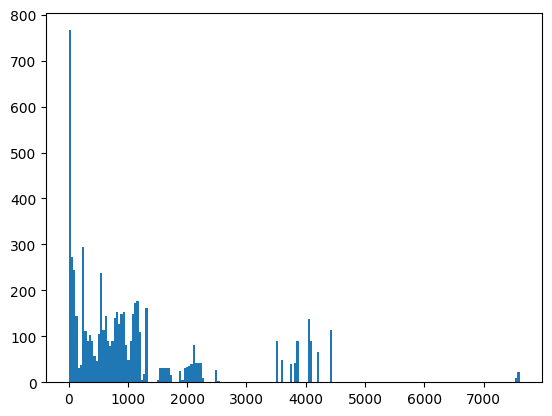

In [19]:
plt.hist(master_df['distance_km'], bins=200)

# TMP

master_df

In [73]:
master_df.head()

,hex,type,flight,r,t,alt_baro,alt_geom,gs,track,baro_rate,...,nav_altitude_fms,rr_lat,rr_lon,lastPosition,gpsOkBefore,gpsOkLat,gpsOkLon,distance_km,sec,num_of_iteration
1338,48ae04,adsc,LOT4,SP-LRE,B788,41000,NaN,NaN,73.22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4034.363060,080000,16000.0
1349,495277,adsc,LOT5N,CS-TSW,B772,37000,NaN,NaN,78.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4417.725667,080000,16000.0
1358,48ae03,adsc,LOT16M,SP-LRD,B788,39000,NaN,NaN,78.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4082.922002,080000,16000.0
1398,48ae26,adsc,LOT6E,SP-LSG,B789,37000,NaN,NaN,78.79,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3742.866412,080000,16000.0
1777,49514b,adsb_icao,TAP120N,CS-TJK,A21N,34325,35100.0,394.0,25.72,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2252.670741,080000,16000.0


In [87]:
tmp_df = master_df.copy()

In [88]:
tmp_df['under_100'] = np.where(tmp_df['distance_km']<100.0, 1, 0)
tmp_df['under_20'] = np.where(tmp_df['distance_km']<20.0, 1, 0)
tmp_df['under_5'] = np.where(tmp_df['distance_km']<5.0, 1, 0)
tmp_df['under_1'] = np.where(tmp_df['distance_km']<1.0, 1, 0)

In [89]:
tmp_df[tmp_df['distance_km'].between(1, 10)].sort_values(by='distance_km')

,hex,type,flight,r,t,alt_baro,alt_geom,gs,track,baro_rate,...,gpsOkBefore,gpsOkLat,gpsOkLon,distance_km,sec,num_of_iteration,under_100,under_20,under_5,under_1
3438,896557,adsb_icao,FDB1836,A6-FMP,B38M,ground,NaN,15.5,NaN,NaN,...,NaN,NaN,NaN,1.004738,080250,16050.0,1,1,1,0
3438,896557,adsb_icao,FDB1836,A6-FMP,B38M,ground,NaN,15.5,NaN,NaN,...,NaN,NaN,NaN,1.004738,080250,16050.0,1,1,1,0
3422,4cadfd,adsb_icao,RYR651E,EI-IHR,B38M,375,550.0,151.7,331.24,-768.0,...,NaN,NaN,NaN,1.005089,080415,16083.0,1,1,1,0
3422,4cadfd,adsb_icao,RYR651E,EI-IHR,B38M,375,550.0,151.7,331.24,-768.0,...,NaN,NaN,NaN,1.005089,080415,16083.0,1,1,1,0
3416,896557,adsb_icao,FDB1836,A6-FMP,B38M,ground,NaN,18.5,NaN,NaN,...,NaN,NaN,NaN,1.012463,080455,16091.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3343,48ad80,adsb_icao,LOT5PG,SP-LMA,E190,5600,5700.0,267.4,143.52,-1024.0,...,NaN,NaN,NaN,9.888012,081320,16264.0,1,1,0,0
3360,48ad83,adsb_icao,LOT640,SP-LMD,E190,1975,2100.0,136.0,331.93,-896.0,...,NaN,NaN,NaN,9.897595,081450,16290.0,1,1,0,0
3360,48ad83,adsb_icao,LOT640,SP-LMD,E190,1975,2100.0,136.0,331.93,-896.0,...,NaN,NaN,NaN,9.897595,081450,16290.0,1,1,0,0
3336,48ad80,adsb_icao,LOT5PG,SP-LMA,E190,6850,6950.0,274.8,140.17,-1280.0,...,NaN,NaN,NaN,9.943244,081220,16244.0,1,1,0,0


In [93]:
tmp_grb_1 = tmp_df.groupby('sec')['under_1'].sum().reset_index()
tmp_grb_5 = tmp_df.groupby('sec')['under_5'].sum().reset_index()
tmp_grb_20 = tmp_df.groupby('sec')['under_20'].sum().reset_index()
tmp_grb_100 = tmp_df.groupby('sec')['under_100'].sum().reset_index()

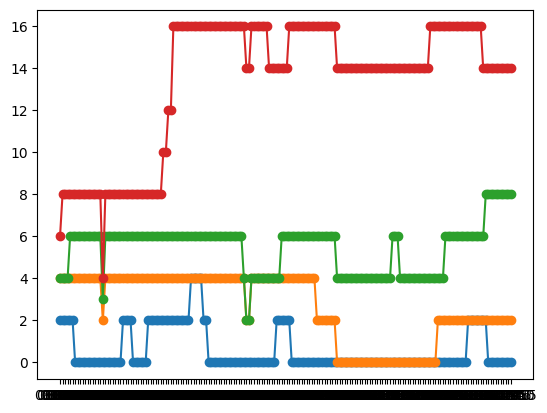

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tmp_grb_1['sec'], tmp_grb_1['under_1'], marker='o', linestyle='-')  # Opcjonalne
plt.plot(tmp_grb_5['sec'], tmp_grb_5['under_5'], marker='o', linestyle='-')  # Opcjonalne
plt.plot(tmp_grb_20['sec'], tmp_grb_20['under_20'], marker='o', linestyle='-')  # Opcjonalne
plt.plot(tmp_grb_100['sec'], tmp_grb_100['under_100'], marker='o', linestyle='-')  # Opcjonalne
